In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip( ),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'E:/CM'

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [65]:
print(len(dataloaders['train']))
print(len(dataloaders['val']))
print(len(dataloaders['test']))

612
72
36


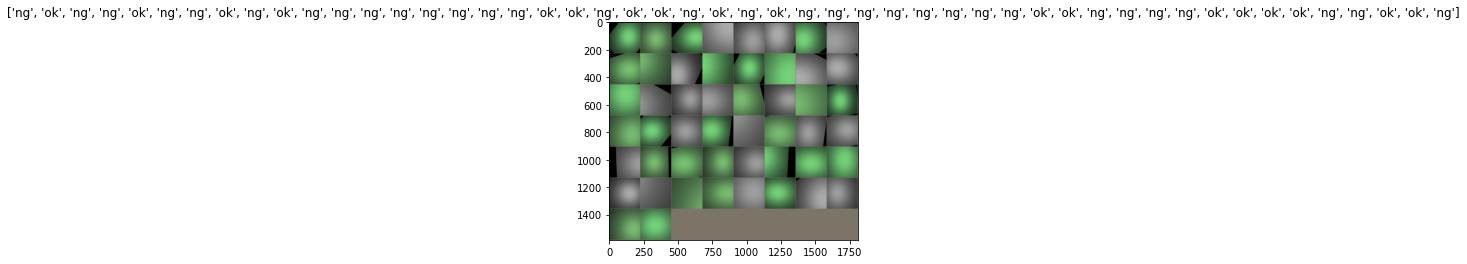

In [4]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict( ))
  best_acc = 0.0

  loss_history = {'train': [], 'val': []}
  acc_history = {'train': [], 'val': []}

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        model.train( )
      else:
        model.eval( )

      running_loss = 0.0
      running_correts = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad( )
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_correts += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_size[phase]
      epoch_acc = running_correts.double() / dataset_size[phase]

      loss_history[phase].append(epoch_loss)
      acc_history[phase].append(epoch_acc)
      
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
  time_elapsed = time.time() - since
  print('학습 완료 걸린시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  return model, loss_history, acc_history

In [6]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far ==num_images:
          model.train(mode = was_training)
          return
      model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True) #사전 학습된 ResNet18 가져오기
num_ftrs = model_ft.fc.in_features #모델에서 feature extraction 후, FC층에 입력되는 특징 수
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) #cpu나 GPU에 model_ft를 할당
criterion = nn.CrossEntropyLoss()

#모든 파라미터를 학습
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#매 7 에포크 마다 학습률 0.1배 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, loss_ft, acc_ft  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


c:\Users\user\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1239 Acc: 0.9524
val Loss: 0.1126 Acc: 0.9525

Epoch 1/9
----------
train Loss: 0.0783 Acc: 0.9705
val Loss: 0.0756 Acc: 0.9547

Epoch 2/9
----------
train Loss: 0.0697 Acc: 0.9747
val Loss: 0.0250 Acc: 0.9981

Epoch 3/9
----------
train Loss: 0.0641 Acc: 0.9758
val Loss: 0.0831 Acc: 0.9553

Epoch 4/9
----------
train Loss: 0.0597 Acc: 0.9773
val Loss: 0.0578 Acc: 0.9628

Epoch 5/9
----------
train Loss: 0.0587 Acc: 0.9779
val Loss: 0.0389 Acc: 0.9883

Epoch 6/9
----------
train Loss: 0.0538 Acc: 0.9802
val Loss: 0.0501 Acc: 0.9758

Epoch 7/9
----------
train Loss: 0.0505 Acc: 0.9812
val Loss: 0.0633 Acc: 0.9681

Epoch 8/9
----------
train Loss: 0.0510 Acc: 0.9814
val Loss: 0.0747 Acc: 0.9669

Epoch 9/9
----------
train Loss: 0.0496 Acc: 0.9817
val Loss: 0.0498 Acc: 0.9747

학습 완료 걸린시간: 449분 29초
Best val Acc: 0.9981


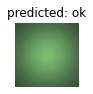

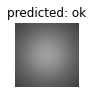

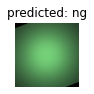

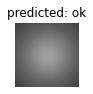

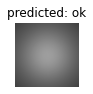

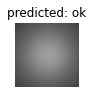

In [8]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False #사전 학습된 모델의 가중치를 상수로  고정. 학습시키지 않음

#새로 생성된 모듈의 파라미터는 기본적으로 requires_grad = True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

#마지막 층의 파라미터만 학습
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_conv, loss_conv, acc_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2330 Acc: 0.9030
val Loss: 0.1139 Acc: 0.9492

Epoch 1/9
----------
train Loss: 0.1739 Acc: 0.9308
val Loss: 0.1201 Acc: 0.9392

Epoch 2/9
----------
train Loss: 0.1628 Acc: 0.9355
val Loss: 0.1119 Acc: 0.9447

Epoch 3/9
----------
train Loss: 0.1579 Acc: 0.9372
val Loss: 0.1273 Acc: 0.9372

Epoch 4/9
----------
train Loss: 0.1542 Acc: 0.9378
val Loss: 0.1466 Acc: 0.9331

Epoch 5/9
----------
train Loss: 0.1573 Acc: 0.9362
val Loss: 0.1502 Acc: 0.9292

Epoch 6/9
----------
train Loss: 0.1467 Acc: 0.9421
val Loss: 0.1737 Acc: 0.9244

Epoch 7/9
----------
train Loss: 0.1462 Acc: 0.9408
val Loss: 0.1672 Acc: 0.9267

Epoch 8/9
----------
train Loss: 0.1494 Acc: 0.9418
val Loss: 0.1251 Acc: 0.9408

Epoch 9/9
----------
train Loss: 0.1463 Acc: 0.9428
val Loss: 0.1814 Acc: 0.9231

학습 완료 걸린시간: 366분 0초
Best val Acc: 0.9492


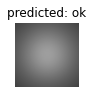

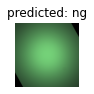

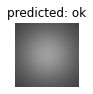

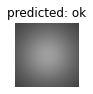

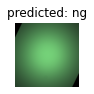

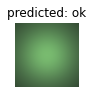

In [10]:
visualize_model(model_conv)

plt.ioff()
plt.show()

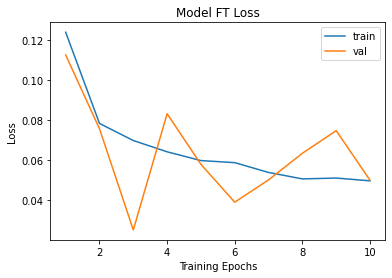

In [13]:
import matplotlib.pyplot as plt

num_epochs = 10

# plot loss progress
plt.title("Model FT Loss")
plt.plot(range(1,num_epochs+1),loss_ft["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_ft["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


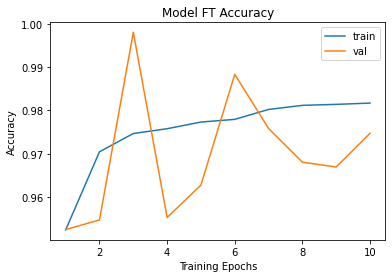

In [14]:

# plot accuracy progress
plt.title("Model FT Accuracy")
plt.plot(range(1,num_epochs+1),acc_ft["train"],label="train")
plt.plot(range(1,num_epochs+1),acc_ft["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [73]:
print(np.mean(acc_ft["val"]))
print(np.max(acc_ft["val"]))
print(np.average(acc_ft["val"]))

print(np.mean(acc_ft["train"]))
print(np.max(acc_ft["train"]))
print(np.average(acc_ft["train"]))

0.9697222222222223
0.9980555555555556
0.9697222222222223
0.9753104575163398
0.9816993464052287
0.9753104575163398


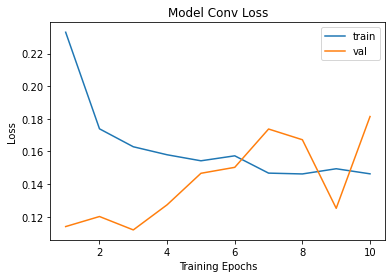

In [15]:

# plot loss progress
plt.title("Model Conv Loss")
plt.plot(range(1,num_epochs+1),loss_conv["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_conv["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


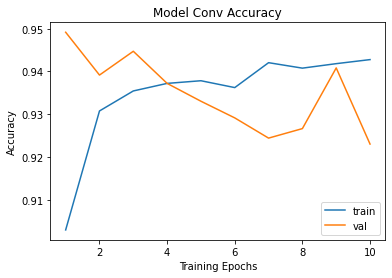

In [16]:

# plot accuracy progress
plt.title("Model Conv Accuracy")
plt.plot(range(1,num_epochs+1),acc_conv["train"],label="train")
plt.plot(range(1,num_epochs+1),acc_conv["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [26]:
torch.save(model_ft.state_dict(), "D:/02.Project/01. Python/.vscode/ResNetFT")    

In [32]:
test_images = image_datasets['test'].classes
test_images

['ng', 'ok']

In [68]:
def acc(model):
    model.eval()
    hit = 0
    total = 0
    dataloader_test =  {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=50, shuffle=True, num_workers=4) for x in ['test']}

    for x, y in dataloader_test:
        pred = model(x.to(device))
        hit = hit + sum( pred.argmax(dim=-1).cpu() == y ).item()
        total = total + x.size(0)

    model.train()
    return hit*100.0 / total


In [69]:


# test_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
# #val_loader = DataLoader(test_datasets, batch_size=32, shuffle=False, num_workers=4)
# val_loader = {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=50, shuffle=True, num_workers=4) for x in ['test']}

print("Test accuracy: ", acc(model_ft))
#print("Train acc: ", acc(model, DC))

ValueError: too many values to unpack (expected 2)

In [42]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,Dataset


test_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
#val_loader = DataLoader(test_datasets, batch_size=32, shuffle=False, num_workers=4)
val_loader = {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=50, shuffle=True, num_workers=4) for x in ['test']}


In [50]:
val_loader

{'test': <torch.utils.data.dataloader.DataLoader at 0x2248ee6dcf8>}

In [57]:

model_ft.eval()
y_label = []
y_predict = []

# for i, (inputs, labels) in enumerate(dataloaders['test']):
#     inputs = inputs.to(device)
#     labels = labels.to(device)

with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        #images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model_ft(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

ValueError: too many values to unpack (expected 2)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x000002249ECF65F8>>
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "c:\Users\user\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


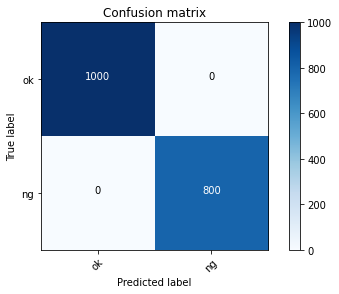

In [55]:

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['ok', 'ng']
plot_confusion_matrix(confusion_mtx, plot_labels)

              precision    recall  f1-score   support

          ok       1.00      1.00      1.00      1000
          ng       1.00      1.00      1.00       800

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



ValueError: shape mismatch: objects cannot be broadcast to a single shape

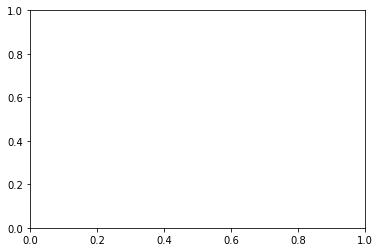

In [56]:
from sklearn.metrics import classification_report
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')